In [3]:
#This notebook will run the soybean model for a given growing season (year)
#The agromanagement settings are defined within the config.py file

import sys, os
this_dir = os.getcwd()
up_dir = os.path.dirname(this_dir)
if not up_dir in sys.path:
    sys.path.append(up_dir)
    
import datetime as dt
import yaml
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

from pcse.fileinput import ExcelWeatherDataProvider, PCSEFileReader
from pcse.base import ParameterProvider
from campbell_diaz.model import CampbellDiazModel
import config

In [4]:
def make_agromanagement(year):
    """Returns the proper crop agromanagement dates for given campaign year

    :param year: The harvest year of the cropping season
    :return: the PCSE agromanagement structure
    """
    campaign_dates = config.agromanagement[year]
    agromanagement = """
    - {campaign_start_date}:
        CropCalendar:
            crop_name: Soybean 
            variety_name: Soybean 
            crop_start_date: {crop_start_date}
            crop_start_type: sowing
            crop_end_date: {crop_end_date}
            crop_end_type: harvest
            max_duration: 300
        TimedEvents:
        StateEvents:
        """
    agro = yaml.safe_load(agromanagement.format(**campaign_dates))
    return agro


In [5]:
def main(year):
    
    agro=make_agromanagement(year)
    weather_data = ExcelWeatherDataProvider(config.weather_fname)
    cropd = PCSEFileReader(config.crop_fname)
    soild = PCSEFileReader(config.soil_fname)
    params = ParameterProvider(cropdata=cropd, soildata=soild,sitedata={})
    model = CampbellDiazModel(params, weather_data, agro)
    model.run_till_terminate()
    output=model.get_output()
    
    df = pd.DataFrame(model.get_output()).set_index("day")
    
#    # Plot results
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8,8))
    for key, axis in zip(df.columns, axes.flatten()):
        df[key].plot(ax=axis, title=key)
    fig.autofmt_xdate()
        
    return model,output


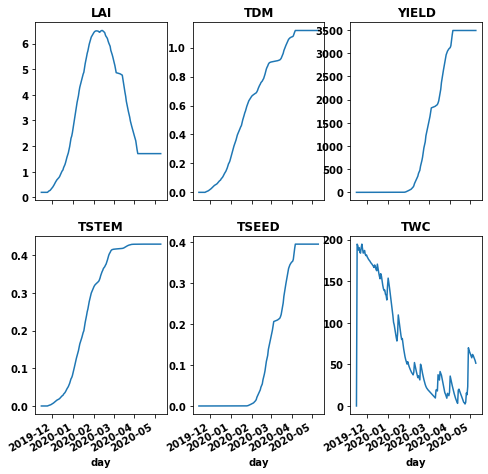

In [6]:
model,output=main(year=2020)